# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Data Pre-Processing  
#### Azdias Dataset  & Feat_info & Cusromers 


### Step 1: Preprocessing
#### Step 1.1: Assess Missing Data
The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the Discussion cell with your findings and decisions at the end of each step that has one!

##### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as feat_info) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. [-1,0]), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
missingazdias = azdias.isnull().sum()
missingazdias

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [7]:
missingazdias = azdias.isnull().sum().sum()
print ('the sum of missing values before processing  {}:'.format(missingazdias))

the sum of missing values before processing  33492923:


In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missed = azdias.isnull().sum()
missed

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

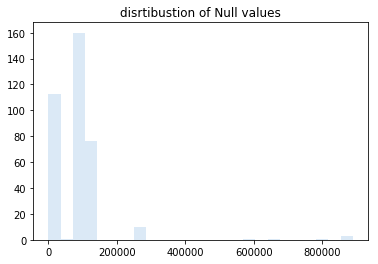

In [9]:
sns.set_palette('Blues')
plt.hist(missed, bins=25 )
plt.title('disrtibustion of Null values')
plt.show()

(array([ 129.,  221.,   10.,    0.,    0.,    0.,    1.,    1.,    0.,    4.]),
 array([      0. ,   89001.6,  178003.2,  267004.8,  356006.4,  445008. ,
         534009.6,  623011.2,  712012.8,  801014.4,  890016. ]),
 <a list of 10 Patch objects>)

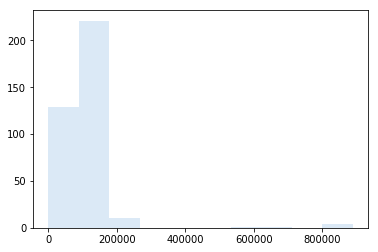

In [10]:
# Investigate patterns in the amount of missing data in each column.
#anathor method for represniting histogram 
plt.hist(missed)

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#dropped whatis value more than  200 K, so we can count values more than 30 and values less than 30 
missed_less_200k = missed[missed <= 200000 ]
missed_more_200k  =  missed[missed >= 200000 ]
print ('number of than 200k is {}'.format(missed_more_200k.shape[0]))

number of than 200k is 16


In [12]:
#remove data with more than 200000 missing values 
azdias.drop(missed_more_200k.index, axis=1, inplace=True)
azdias.shape

(891221, 350)

In [13]:
missed_less_200k

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
CJT_TYP_6                       4854
D19_BANKEN_ANZ_12                  0
D19_BANKEN_ANZ_24                  0
D19_BANKEN_DATUM                   0
D19_BANKEN_DIREKT                  0
D

In [14]:
missed_more_200k

ALTER_KIND1                    810163
ALTER_KIND2                    861722
ALTER_KIND3                    885051
ALTER_KIND4                    890016
ALTERSKATEGORIE_FEIN           262947
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_SOZIALES                   257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_VERSI_ONLINE_QUOTE_12      257113
EXTSEL992                      654153
KK_KUNDENTYP                   584612
dtype: int64

In [15]:
# How much data is missing in each row of the dataset?
missed_1 = azdias.isnull().sum(axis =1)
missed_1

0         236
1           0
2           0
3           2
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11        237
12         64
13         67
14        237
15        123
16          2
17        237
18          0
19          0
20        126
21          0
22          0
23        123
24        237
25          2
26        193
27          0
28          0
29          0
         ... 
891191      0
891192      0
891193      0
891194      0
891195      0
891196      0
891197      0
891198      0
891199      0
891200      0
891201      0
891202      0
891203     69
891204      0
891205      0
891206      0
891207      0
891208      0
891209      0
891210      0
891211      0
891212      0
891213      0
891214      0
891215      0
891216      6
891217      0
891218      2
891219      0
891220      0
Length: 891221, dtype: int64

(array([  7.51244000e+05,   8.70000000e+01,   2.90210000e+04,
          5.06800000e+03,   6.93000000e+02,   5.87100000e+03,
          3.00000000e+00,   5.97600000e+03,   5.86000000e+02,
          9.26720000e+04]),
 array([   0. ,   24.4,   48.8,   73.2,   97.6,  122. ,  146.4,  170.8,
         195.2,  219.6,  244. ]),
 <a list of 10 Patch objects>)

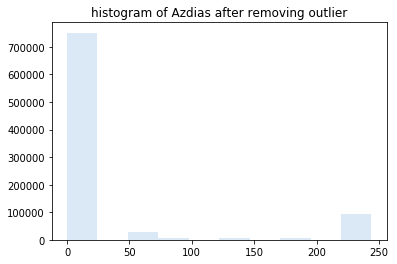

In [16]:
plt.title('histogram of Azdias after removing outlier')
plt.hist(missed_1)

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missed_less_20 = azdias [missed_1 < 20 ]
missed_more_20  =  azdias [missed_1 >= 20 ]
print ('number of than 20 is {}'.format(missed_more_20.shape[0]))

number of than 20 is 144319


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
column_with_no_missed_data = missed_1[missed_1==0] 
column_with_no_missed_data = column_with_no_missed_data.index
column_with_no_missed_data

Int64Index([     1,      2,      4,      5,      6,      7,      8,      9,
                10,     18,
            ...
            891209, 891210, 891211, 891212, 891213, 891214, 891215, 891217,
            891219, 891220],
           dtype='int64', length=696942)

In [19]:
'''
for col in azdias.columns[0:5]:
    fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
    sns.countplot(missed_less_20.loc[:,col], ax=axes[0],  palette="Greens")
    sns.countplot(missed_more_20.loc[:,col], ax=axes[1], palette="Blues")
    '''

'\nfor col in azdias.columns[0:5]:\n    fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)\n    sns.countplot(missed_less_20.loc[:,col], ax=axes[0],  palette="Greens")\n    sns.countplot(missed_more_20.loc[:,col], ax=axes[1], palette="Blues")\n    '

In [20]:
# Load the feature information and view the first 15 lines
feat_info1 = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del feat_info['Unnamed: 0']
del feat_info1['Unnamed: 0']

In [21]:
feat_info.tail()

,Attribute,Description,Value,Meaning
2253,NaN,NaN,2,smart
2254,NaN,NaN,3,fair supplied
2255,NaN,NaN,4,price driven
2256,NaN,NaN,5,seeking orientation
2257,NaN,NaN,6,indifferent


In [22]:
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [23]:
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
feat_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [24]:
unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
unknowns

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [25]:
import pickle 
pickle.dump(azdias, open("azdias.pickle", "wb"))

In [26]:
pickle.dump(unknowns, open("unknowns.pickle", "wb"))

In [27]:
azdias = pickle.load(open("azdias.pickle", "rb"))

In [28]:
col_na = azdias.shape[0] - azdias.count()
col_na.sort_values()

LNR                                 0
FINANZ_HAUSBAUER                    0
FINANZ_ANLEGER                      0
D19_WEIN_FEINKOST                   0
D19_VOLLSORTIMENT                   0
D19_VERSICHERUNGEN                  0
D19_VERSI_ONLINE_DATUM              0
D19_VERSI_OFFLINE_DATUM             0
D19_VERSI_DATUM                     0
D19_VERSI_ANZ_24                    0
D19_VERSI_ANZ_12                    0
D19_VERSAND_REST                    0
D19_VERSAND_ONLINE_DATUM            0
D19_VERSAND_OFFLINE_DATUM           0
D19_VERSAND_DATUM                   0
D19_VERSAND_ANZ_24                  0
D19_VERSAND_ANZ_12                  0
D19_TIERARTIKEL                     0
D19_TELKO_REST                      0
D19_TELKO_ONLINE_DATUM              0
D19_TELKO_OFFLINE_DATUM             0
D19_TELKO_MOBILE                    0
D19_TELKO_DATUM                     0
D19_TELKO_ANZ_24                    0
D19_TELKO_ANZ_12                    0
D19_TECHNIK                         0
FINANZ_MINIM

In [29]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [30]:
cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [31]:
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(891221, 343)

In [ ]:
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print(azdias.shape)

azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)

azdias.shape

In [ ]:
print ('mulit feature {}'.format(multi_feature))

In [ ]:

print ('binary_feature{}'.format(binary_feature))

In [ ]:
print ('categorical is {}'.format(categorical_attrib))

In [ ]:

azdias[multi_feature].nunique()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
sns.countplot(azdias[multi_feature].nunique(), ax=axes[0],  palette="Reds")
sns.countplot(azdias[categorical_attrib].nunique(), ax=axes[1], palette="Greens")

In [ ]:
azdias[multi_feature].nunique()

In [ ]:
encoded_azdias.head()


#### re-Encoded Categorical Variables 

In [ ]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, missed_less_20[feature].unique()))

In [ ]:
for feature in multi_feature:
    encoded_azdias.drop(feature , axis=1 )

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
encoded_azdias['DECADE'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
encoded_azdias['MOVEMENT'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']

In [ ]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [ ]:

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3,
               '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3,
                   '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded_azdias['WEALTH'] = encoded_azdias['CAMEO_INTL_2015']
encoded_azdias['LIFE_STAGE'] = encoded_azdias['CAMEO_INTL_2015']

In [ ]:
encoded_azdias['WEALTH'].replace(wealth_dict, inplace=True) 
encoded_azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [ ]:
encoded_azdias=encoded_azdias.replace({col:['XX','X']},np.nan)

In [ ]:
encoded_azdias.info()

In [ ]:
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

In [ ]:
for column in range(feat_info.shape[1]):
    missing_or_unknown = feat_info.iloc[column]['missing_or_unknown'].strip('[]').split(',')
    missing_or_unknown = [float(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[column]['attribute']: missing_or_unknown}, np.nan)
        azdias=azdias.replace({column:['XX','X']},np.nan)

In [ ]:
azdias.info()

#### Step 1.2.1: Re-Encode Categorical Features
For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:

For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
multi_feature=[]
single_feature = []
binary_feature =[]
for x in categorical_attrib :
    if (len(missed_less_20[x].unique())>2):
        multi_feature.append(x)
    elif (len(missed_less_20[x].unique())==2):
        binary_feature.append(x)
print ('mulit feature {}'.format(multi_feature))

In [ ]:
azdias[multi_feature].nunique()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
sns.countplot(azdias[multi_feature].nunique(), ax=axes[0],  palette="Reds")
sns.countplot(azdias[categorical_attrib].nunique(), ax=axes[1], palette="Greens"

In [ ]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, missed_less_20[feature].unique()))

In [ ]:

for feature in multi_feature:
    encoded_azdias.drop(feature , axis=1 )

In [ ]:
encoded_azdias.head()

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
encoded_azdias['DECADE'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
encoded_azdias['MOVEMENT'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']

In [ ]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3,
               '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3,
                   '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

In [ ]:

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded_azdias['WEALTH'] = encoded_azdias['CAMEO_INTL_2015']
encoded_azdias['LIFE_STAGE'] = encoded_azdias['CAMEO_INTL_2015']

In [ ]:

encoded_azdias['WEALTH'].replace(wealth_dict, inplace=True) 
encoded_azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [ ]:
encoded_azdias=encoded_azdias.replace({col:['XX','X']},np.nan)

In [ ]:
encoded_azdias.info()

In [ ]:
encoded_azdias = encoded_azdias.convert_objects(convert_numeric=True)

In [ ]:
encoded_azdias.tail()

#### Step 1.3: Create a Cleaning Function
Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the general demographics data.
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',  sep=';')
    
    
    # Identify missing or unknown data values and convert them to NaNs.

    # Identify missing or unknown data values and convert them to NaNs.
    for column in range(feat_info.shape[1]):
        missing_or_unknown = feat_info.iloc[column]['missing_or_unknown'].strip('[]').split(',')
        missing_or_unknown = [float(value) if (float(value)!='X' and float(value)!='XX' and float(value)!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            azdias = azdias.replace({feat_info.iloc[column]['attribute']: missing_or_unknown}, np.nan)

    missed = azdias.isnull().sum()
    missed
    #dropped whatis value more than  200 K, so we can count values more than 30 and values less than 30 
    missed_less_200k = missed[missed <= 200000 ]
    missed_more_200k  =  missed[missed >= 200000 ]
    #print ('number of than 200k is {}'.format(missed_more_200K.shape[0]))
    
    #remove data with more than 200000 missing values 
    azdias.drop(missed_more_200k.index, axis=1, inplace=True)
    # Put in code here to execute all main cleaning steps:
    
    # How much data is missing in each row of the dataset?
    missed_1 = azdias.isnull().sum(axis =1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.

    missed_less_20 = azdias [missed_1 < 20 ]
    missed_more_20  =  azdias [missed_1 >= 20 ]
    print ('number of than 20 is {}'.format(missed_more_20.shape[0]))
        
        
     #How many features are there of each data type?
    feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    del feat_info['Unnamed: 0']
    del feat_info1['Unnamed: 0']
    feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
    pd.set_option('display.max_rows', 500)
    feat_info
    unknowns = []
    for attribute in feat_info['Attribute'].unique():
        
        _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
        _ = _.split(',')
        unknowns.append(_)
    
    unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
    unknowns.columns = ['attribute', 'missing_or_unknown']
    unknowns
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    encoded_azdias = missed_less_20.replace({'OST_WEST_KZ':{'W':0,'O':1}})
    
    #dropping mulitfeature 
    for feature in multi_feature:
        encoded_azdias.drop(feature , axis=1 )
    
    mixed_feat_info = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed_feat_info = [x for x in mixed_feat_info if x in missed_less_20.columns] 
    azdias[mixed_feat_info].nunique()
    
    
    new_feat_info = feat_info[feat_info['type'] == 'mixed']
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    encoded_azdias['DECADE'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
    encoded_azdias['MOVEMENT'] = encoded_azdias['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3,
               '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3,
                   '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    encoded_azdias['WEALTH'] = encoded_azdias['CAMEO_INTL_2015'] 
    encoded_azdias['LIFE_STAGE'] = encoded_azdias['CAMEO_INTL_2015']
    
    encoded_azdias['WEALTH'].replace(wealth_dict, inplace=True) 
    encoded_azdias['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

    # convert missing value codes into NaNs, ...
    
    encoded_azdias = encoded_azdias.convert_objects(convert_numeric=True)
    # remove selected columns and rows, ...

    display(encoded_azdias)
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    return encoded_azdias

### 2- Feature Transformation 

In [ ]:
(df.isnull().sum()/df.sum()).sort_values(ascending= False)

In [ ]:
#the percentage of null rows  in data 
(df.shape[0] - df_1.shape[0])/df.shape[0]

In [ ]:
df_1 = df_1.convert_objects(convert_numeric=True)

In [ ]:
l = df_1['CAMEO_DEU_2015'].unique()
l

In [ ]:
df_1.replace (to_replace = l, value = np.NaN, regex = True, inplace = True)


In [ ]:
df_1.info()


In [ ]:
df_1.isnull().sum()

In [ ]:
# Imput of missed data 
fill_missing = Imputer(strategy='mean')
df_imputed  = pd.DataFrame(fill_missing .fit_transform(df_1))

In [ ]:
df_imputed.head()

In [ ]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_imputed = pd.DataFrame(scaler.fit_transform(df_imputed), columns = df_imputed.columns)

In [ ]:
df_imputed.head()


#### Step 2.2: Perform Dimensionality Reduction¶


In [ ]:
# Apply PCA to the data.
pca =PCA()
df_pca = pca.fit_transform(df_imputed)

In [ ]:
df_pca

In [ ]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    val = pca.explained_variance_ratio_
    num_of_component = len (val)
    ind = np.arange(num_of_component)  
    plt.figure(figsize=(14 ,8))
    ax = plt.subplot(111)
    ax.annotate(r"%s%%" % ((str(val[0]*100)[:4])), (ind[0]+0.2, val[0]), va="bottom", ha="center", fontsize=12)
    ax.annotate(r"%s%%" % ((str(val[-1]*100)[:4])), (ind[-1]+0.2, val[-1]), va="bottom", ha="center", fontsize=12)
    cumvals = np.cumsum(val)
    ax.bar(ind, val)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Percentage (%)")
    plt.title(' Variance Per  Component')
    
scree_plot(pca)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.
def do_pca(n, data):
    pca = PCA(n)
    X_pca=pca.fit_transform(data)
    return pca, X_pca

In [ ]:
do_pca(30,df_imputed)

In [ ]:

# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
azdias_pca = pca.fit_transform(df_imputed)

In [ ]:
scree_plot(pca)


### Discussion 2.2: Perform Dimensionality Reduction
extract the most variance of dataset after applying PCA
drawing variance per principle comonent
refit instant pca to assure the transformation
retaining 30 principle component as it around 80 % of the vairiance

### Step 2.3: Interpret Principal Components
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights(n,pca,df):
    name_list=list(df.columns)
    weights_list=list(pca.components_[n])
    df =pd.DataFrame(list(zip(name_list, weights_list)))
    df.set_axis(['Feature', 'Weights'], axis=1, inplace=True)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Feature', inplace=True)
    return df

In [ ]:
for i in range (3):
    print('\n Top 3- components {}\n'.format(i))
    print(weights(i,pca,df_1).tail(5))
    print('-----------------------------------------------')

In [ ]:
for i in range(3):
    print('\n Top 3+ components {}\n'.format(i))
    print(weights(i,pca,df_1).head(5))
    print('-----------------------------------------------')

In [ ]:

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.ylabel("Ratio of variance explained (%)")
plt.title("Variance explaine for component")
plt.xlabel("Principal component")

plt.show()

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display (df_imputed.tail())

#### Discussion 2.3: Interpret Principal Components
from data dictionary we can interpret to know the prinicple component affect on analysis and weight by negative or postive
for component 0 people with lower interest
postive
Feature
CAMEO_DEUG_2015 0.192136 PLZ8_ANTG2 0.191733 MOVEMENT 0.189757 CAMEO_DEU_2015 0.186615 PLZ8_ANTG3 0.186137

negative
               Weights
Feature
KBA13_ANZAHL_PKW -0.192810 CAMEO_INTL_2015 -0.198454 LP_STATUS_GROB -0.204203 LP_STATUS_FEIN -0.206677 KKK -0.2125

===============================================================================

for compeonet 1 people with age more than 60
psotive
Feature
ALTERSKATEGORIE_GROB 0.248386 FINANZ_VORSORGER 0.230813 SEMIO_ERL 0.196352 SEMIO_LUST 0.173735 RETOURTYP_BK_S 0.164255

negative
Top 3- components 1

                    Weights
Feature
SEMIO_REL -0.222038 FINANZ_SPARER -0.234101 RELAT_AB -0.255270 DECADE -0.255270 PRAEGENDE_JUGENDJAHRE -0.255270

======================================================================================

for component 2 male tend to be actual and not dreamy
postive
                 Weights
Feature
SEMIO_VERT 0.343464 SEMIO_SOZ 0.270489 SEMIO_FAM 0.269855 SEMIO_KULT 0.259609 FINANZ_MINIMALIST 0.144171

negative
Top 3- components 2

         Weights
Feature
SEMIO_ERL -0.203062 SEMIO_KRIT -0.278884 SEMIO_DOM -0.313511 SEMIO_KAEM -0.343827 ANREDE_KZ -0.371312

In [ ]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
    
    # compute the average within-cluster distances.
def get_kmeans_score(data ,center):
    kmeans = KMeans(n_clusters=center, random_state=0)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,12))
for center in centers : 
    scores.append(get_kmeans_score(azdias_pca,center))
display(scores)

In [ ]:

display (centers)

In [ ]:
plt.plot(scores,centers,  linestyle='-', marker='o', color='r')
plt.xlabel('No. clusters ')
plt.ylabel('avg distance score')
plt.title(' score VS n_cluster')

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10, random_state=0)
model = kmeans.fit(azdias_pca)
Score = np.abs(model.score(azdias_pca))
cluster =  model.predict(azdias_pca)

In [ ]:
display(pd.DataFrame(cluster).head())

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_df = clean_data(customer)

In [ ]:
customer_df = customer_df.convert_objects(convert_numeric=True)
customer_df.info()

In [ ]:
n = customer_df['CAMEO_DEU_2015'].unique()
n

In [ ]:

customer_df.replace (to_replace = n, value = np.NaN, regex = True, inplace = True)

In [ ]:
customer_df = customer_df.convert_objects(convert_numeric=True)


In [ ]:
customer_df.info()


In [ ]:
customer_df_new=customer_df.dropna(axis=1)


In [ ]:
customer_df_new.info()


In [ ]:
#imputer
scaler = StandardScaler()
customer_df_new= pd.DataFrame(scaler.fit_transform(customer_df_new), columns = customer_df_new.columns)

In [ ]:
customer_pca = pca.transform(customer_df_new)

In [ ]:

customer_cluster =  model.predict(customer_pca)

## Apply previouse to customer data 

In [ ]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
train = clean_data(mailout_train)
train.head()

In [ ]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = train['RESPONSE']
del train['RESPONSE']
X = train
y.shape, X.shape

In [ ]:

# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del X['CAMEO_DEUG_2015']
del X['CAMEO_INTL_2015']
del X['EINGEFUEGT_AM']

# Perform imputation on train df
imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()

In [ ]:
# Apply feature scaling to the train df
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

In [ ]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

In [ ]:
# LogisticRegression

logreg = LogisticRegression()
print(classifier_roc(logreg, {}))

In [ ]:
# RandomForestClassifier

rfc = RandomForestClassifier()
print(classifier_roc(rfc, {}))

In [ ]:
# AdaBoostClassifier

ada = AdaBoostClassifier()
print(classifier_roc(ada, {}))

In [ ]:
# GradientBoostingClassifier

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

In [ ]:
# SupportVectorMachine

svc = SVC()
print(classifier_roc(svc, {}))

In [ ]:
# Optimize the AdaBoostClassifier using GridSearchCV

start = time.time()

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
# This version of the clean dataset does not remove rows since I need to predict on 
# all rows of the test dataset.  

def clean_data2(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df1: Customer demographics DataFrame
        df2: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df1.columns:
        if df1[col].dtype == np.int64:
            df1[col] = df1[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in unknowns['attribute']:
        if row in df1.columns:
            na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # remove selected columns, ...
    # These columns were the ones above that had
    # > 200000 missing values in the azdias dataframe
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # select, re-encode, and engineer column values
    df1['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df1[col], prefix = col)
        df1 = pd.concat([df1, dummy], axis = 1)
        
    df1.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # Return the cleaned dataframe.
    return df1

In [ ]:
# Clean the test data (may need to rerun cell with cleaning function, loading unknowns.pickle)
test = clean_data2(test, unknowns)
test.head()

In [ ]:
# Copy LNR column for later when generating Kaggle submission csv 
test_LNR = test['LNR']

In [ ]:

# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del test['CAMEO_DEUG_2015']
del test['CAMEO_INTL_2015']
del test['EINGEFUEGT_AM']

# Perform imputation on train df
test = pd.DataFrame(imputer.transform(test), columns = test.columns)
test.head()

In [ ]:

# Apply feature scaling to the test df
test = pd.DataFrame(scaler.transform(test), columns = test.columns)
test.head()

In [ ]:

# Rerun AdaBoostClassifier with optimized parameters
param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.1],
             'n_estimators': [50]}

best_model = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
best_model.fit(X, y)

In [ ]:
preds = best_model.predict_proba(test)
preds[:10]

In [ ]:
# Generate a csv file to be submitted to Kaggle with the LNR id and prediction of response as columns.
# Use second column of the array as the probabilities to be entered (probability of a positive response).
# Print the first few lines of the kaggle dataframe.
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

In [ ]:
# LogisticRegression
logistic_regression  = LogisticRegression()
print(classifier_roc(logistic_regression, {}))

In [ ]:

# GradientBoostingClassifier

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

In [ ]:

# SupportVectorMachine

svc = SVC()
print(classifier_roc(svc, {}))

In [ ]:

# Optimize the AdaBoostClassifier using GridSearchCV

start = time.time()

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time